In [1]:
import pandas as pd
import numpy as np 

from collections import Counter
from itertools import combinations

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix

from boruta import BorutaPy


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
paths = {
    "ADNIMERGE": "data/ADNIMERGE_17Apr2025.csv",
    "APOERES": "data/APOERES_17Apr2025.csv",
    "CDR": "data/CDR_24Apr2025.csv",
    "FAQ": "data/FAQ_24Apr2025.csv",
    "NEUROBAT": "data/NEUROBAT_17Apr2025.csv",
    "DEMOG": "data/RMT_PTDEMOG_17Apr2025.csv",
    "PSYCH": "data/UWNPSYCHSUM_17Apr2025.csv"
}

dfs = {name: pd.read_csv(path) for name, path in paths.items()}

df_adni = dfs["ADNIMERGE"]

C:\Users\plech\AppData\Local\Temp\ipykernel_9900\4170551003.py:11: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in paths.items()}
C:\Users\plech\AppData\Local\Temp\ipykernel_9900\4170551003.py:11: DtypeWarning: Columns (79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(path) for name, path in paths.items()}


In [3]:
# Filter each dataset to include only baseline records (VISCODE == 'bl'),
# ensuring consistency by using only the first visit per subject across all files.
# This avoids mixing longitudinal follow-up data and keeps the target (DX_bl) aligned.
for name in dfs:
    if 'VISCODE' in dfs[name].columns:
        dfs[name] = dfs[name][dfs[name]['VISCODE'] == 'bl']

In [4]:
for name, df in dfs.items():
    has_rid = 'RID' in df.columns
    print(f"{name}: {'has RID' if has_rid else 'no RID'}")


ADNIMERGE: has RID
APOERES: has RID
CDR: has RID
FAQ: has RID
NEUROBAT: has RID
DEMOG: no RID
PSYCH: has RID


In [5]:
print(dfs['DEMOG'].columns)

Index(['RMT_PHASE', 'ADNIOnlineID', 'PTID', 'RMT_Timepoint', 'RMT_StatusDate',
       'Age_Baseline', 'Gender', 'LatinoEthnicity', 'Latino_MX', 'Latino_PR',
       'Latino_CB', 'Latino_Other', 'Race_AmerIndian', 'Race_Asian',
       'Race_AfricanAmerican', 'Race_PacificIslander', 'Race_White',
       'Race_Unknown', 'Race_PreferNotSay', 'RMT_Education',
       'RMT_ADI_NATRANK_v2021', 'RMT_ADI_STATERANK_v2021'],
      dtype='object')


In [6]:
# Remove feature DEMOG because it has no RID for merge
_ = dfs.pop('DEMOG', None)

In [7]:
dfs.keys()

dict_keys(['ADNIMERGE', 'APOERES', 'CDR', 'FAQ', 'NEUROBAT', 'PSYCH'])

In [8]:
# Start merging all datasets using 'RID' as the key.
# ADNIMERGE is used as the base since it contains the diagnosis labels (DX_bl).
# Perform a left join to retain all records from ADNIMERGE, even if some datasets lack entries for a given RID.

df_merged = dfs['ADNIMERGE']

for df in dfs:
    if df != 'ADNIMERGE':     
        df_merged = df_merged.merge(dfs[df], on='RID', how='left', suffixes=('', f'_{df.lower()}'))

# Drop duplicate columns created during merging to ensure feature uniqueness
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
# Keep only rows that have a known baseline diagnosis (DX_bl), required for supervised classification
df = df_merged.dropna(subset=['DX_bl'])


In [9]:
print(df_merged['DX_bl'].value_counts())
print(df_merged['DX'].value_counts())

df = df.drop('DX', axis=1)

DX_bl
LMCI    690
CN      542
EMCI    423
AD      411
SMC     353
Name: count, dtype: int64
DX
MCI         1101
CN           895
Dementia     413
Name: count, dtype: int64


In [10]:
# Map DX_bl string labels to integer codes
dx_mapping = {
    "AD": 0,     # Alzheimer's Disease
    "CN": 1,     # Cognitively Normal
    "SMC": 2,    # Significant Memory Concern
    "EMCI": 3,   # Early Mild Cognitive Impairment
    "LMCI": 4    # Late Mild Cognitive Impairment
}

df['DX_bl'] = df['DX_bl'].map(dx_mapping)

In [11]:
df['DX_bl'].value_counts()

DX_bl
4    690
1    542
3    423
0    411
2    353
Name: count, dtype: int64

In [12]:
print("Original ADNIMERGE shape (all visits, unfiltered):", df_adni.shape)
print("Merged dataset shape (baseline only, before dropping missing targets):", df_merged.shape)
print("Final dataset shape (baseline only, with non-null diagnosis):", df.shape)

Original ADNIMERGE shape (all visits, unfiltered): (16421, 116)
Merged dataset shape (baseline only, before dropping missing targets): (2430, 273)
Final dataset shape (baseline only, with non-null diagnosis): (2419, 272)


In [13]:
df.shape

(2419, 272)

In [14]:
# Drop columns with more than 55% missing values
threshold = 0.55
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index
df_clean = df.drop(columns=cols_to_drop)
df_clean.shape

(2419, 189)

In [15]:
cols_duplicated = {}
cols = df_clean.columns.tolist()
for x, y in combinations(cols, 2):
    df_x = df_clean[x]
    df_y = df_clean[y]
    
    n = 0
    for a, b in zip(df_x, df_y):
        if a == b or (pd.isna(a) and pd.isna(b)):
            n += 1
    if len(df_x)*0.9 < n:        
        cols_duplicated[x,y] = n

In [16]:
# sort_cols_duplicated = sorted(cols_duplicated.items())
# sort_cols_duplicated

sort_cols_duplicated = sorted(cols_duplicated.items(), key=lambda item: item[1], reverse=True)
sort_cols_duplicated, len(sort_cols_duplicated)

([(('COLPROT', 'ORIGPROT'), 2419),
  (('EXAMDATE', 'EXAMDATE_bl'), 2419),
  (('FDG', 'FDG_bl'), 2419),
  (('AV45', 'AV45_bl'), 2419),
  (('ABETA', 'ABETA_bl'), 2419),
  (('TAU', 'TAU_bl'), 2419),
  (('PTAU', 'PTAU_bl'), 2419),
  (('CDRSB', 'CDRSB_bl'), 2419),
  (('ADAS11', 'ADAS11_bl'), 2419),
  (('ADAS13', 'ADAS13_bl'), 2419),
  (('ADASQ4', 'ADASQ4_bl'), 2419),
  (('MMSE', 'MMSE_bl'), 2419),
  (('RAVLT_immediate', 'RAVLT_immediate_bl'), 2419),
  (('RAVLT_learning', 'RAVLT_learning_bl'), 2419),
  (('RAVLT_forgetting', 'RAVLT_forgetting_bl'), 2419),
  (('RAVLT_perc_forgetting', 'RAVLT_perc_forgetting_bl'), 2419),
  (('LDELTOTAL', 'LDELTOTAL_BL'), 2419),
  (('TRABSCOR', 'TRABSCOR_bl'), 2419),
  (('FAQ', 'FAQ_bl'), 2419),
  (('MOCA', 'MOCA_bl'), 2419),
  (('EcogPtMem', 'EcogPtMem_bl'), 2419),
  (('EcogPtLang', 'EcogPtLang_bl'), 2419),
  (('EcogPtVisspat', 'EcogPtVisspat_bl'), 2419),
  (('EcogPtPlan', 'EcogPtPlan_bl'), 2419),
  (('EcogPtOrgan', 'EcogPtOrgan_bl'), 2419),
  (('EcogPtDivatt',

In [17]:
pd.options.display.max_columns = None
df_clean

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,IMAGEUID_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,PHASE_faq,PTID_faq,VISCODE_faq,VISCODE2_faq,VISDATE_faq,SOURCE,FAQFINAN,FAQFORM,FAQSHOP,FAQGAME,FAQBEVG,FAQMEAL,FAQEVENT,FAQTV,FAQREM,FAQTRAVL,FAQTOTAL,ID_faq,SITEID_faq,USERDATE_faq,update_stamp_faq,PHASE_neurobat,PTID_neurobat,VISCODE_neurobat,VISCODE2_neurobat,VISDATE_neurobat,CLOCKCIRC,CLOCKSYM,CLOCKNUM,CLOCKHAND,CLOCKTIME,CLOCKSCOR,COPYCIRC,COPYSYM,COPYNUM,COPYHAND,COPYTIME,COPYSCOR,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,CATANINTR,TRAASCOR,TRAAERRCOM,TRAAERROM,TRABSCOR_neurobat,TRABERRCOM,TRABERROM,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,SITEID_neurobat,USERDATE_neurobat,update_stamp_neurobat,PHASE_psych,VISCODE_psych,VISCODE2_psych,EXAMDATE_psych,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2,update_stamp_psych
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,1,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.33615,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,-4.310280,-4.114430,2005-09-08,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,-4.310280,-4.114430,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33615,NaN,0.0,0.0,0,0,2023-07-07 04:59:40.0,ADNI1,011_S_0002,bl,bl,2005-09-08,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,107.0,2005-09-08,2005-09-08 00:00:00.0,ADNI1,011_S_0002,bl,bl,2005-09-08,1.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,0.0,29.0,0.0,0.0,112.0,1.0,0.0,5.0,4.0,6.0,0.0,16.0,30.0,107.0,2005-09-09,2014-08-26 16:22:44.0,ADNI1,bl,bl,2005-09-08,0.405,-0.041,0.140,0.739,-0.310,2023-12-11 14:53:52.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,0,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.10860,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,-16.244900,-15.829900,2005-09-12,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,-16.244900,-15.829900,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.10860,NaN,0.0,0.0,0,0,2023-07-07 04:59:40.0,ADNI1,011_S_0003,bl,bl,2005-09-12,1.0,2.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,10.0,8

In [18]:
drop_cols = [
    "EXAMDATE",
    "PHASE_faq",
    "PTID_faq",
    "RID",
    "USERDATE_faq",
    "USERDATE_neurobat",
    "VISCODE",
    "VISCODE_faq",
    "VISDATE_faq",
    "update_stamp",
    "update_stamp_faq",
    "update_stamp_neurobat",
    "update_stamp_psych",
]
others_Cols = []
for (x, y), n in sort_cols_duplicated:
    if not y in drop_cols:
        drop_cols.append(y)

df = df_clean.drop(columns=drop_cols)
df


,COLPROT,PTID,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,mPACCdigit,mPACCtrailsB,Years_bl,SOURCE,FAQFINAN,FAQFORM,FAQSHOP,FAQGAME,FAQBEVG,FAQMEAL,FAQEVENT,FAQTV,FAQREM,FAQTRAVL,FAQTOTAL,ID_faq,SITEID_faq,CLOCKCIRC,CLOCKSYM,CLOCKTIME,CLOCKSCOR,COPYSCOR,AVTOT1,AVERR1,AVTOT2,AVERR2,AVTOT3,AVERR3,AVTOT4,AVERR4,AVTOT5,AVERR5,AVTOT6,AVERR6,AVTOTB,AVERRB,CATANIMSC,CATANPERS,TRAASCOR,TRAAERRCOM,TRABSCOR_neurobat,TRABERRCOM,AVDEL30MIN,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,ADNI1,011_S_0002,11,1,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.33615,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,-4.310280,-4.114430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,107.0,1.0,0.0,1.0,4.0,5.0,7.0,0.0,7.0,0.0,9.0,0.0,10.0,0.0,11.0,0.0,5.0,2.0,4.0,1.0,15.0,2.0,29.0,0.0,112.0,1.0,5.0,4.0,6.0,0.0,16.0,30.0,0.405,-0.041,0.140,0.739,-0.310
1,ADNI1,011_S_0003,11,0,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.10860,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,-16.244900,-15.829900,0.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,10.0,8.0,107.0,1.0,0.0,0.0,2.0,4.0,3.0,0.0,6.0,0.0,4.0,0.0,5.0,0.0,4.0,0.0,3.0,1.0,1.0,2.0,10.0,0.0,57.0,0.0,148.0,1.0,0.0,0.0,1.0,0.0,11.0,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,ADNI1,022_S_0004,22,4,67.5,Male,10,Hisp/Latino,White,Married,0.0,NaN,NaN,1501.0,153.1,13.29,1.0,14.33,21.33,6.0,27.0,37.0,7.0,4.0,36.3636,4.0,271.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,64631.0,39605.0,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,-8.421500,-9.449350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,10.0,1.0,0.0,1.0,4.0,5.0,4.0,0.0,6.0,1.0,8.0,1.0,8.0,1.0,11.0,0.0,6.0,0.0,2.0,1.0,22.0,0.0,67.0,1.0,271.0,3.0,7.0,6.0,13.0,1.0,NaN,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,ADNI1,011_S_0005,11,1,73.7,Male,16,Not Hisp/Latino,White,Married,0.0,1.25956,NaN,547.3,337.0,33.43,0.0,8.67,14.67,4.0,29.0,37.0,4.0,4.0,44.4444,12.0,90.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32246.0,34062.0,7075.0,1116630.0,4433.0,24788.0,21614.0,1640770.0,-1.888680,-1.565830,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,107.0,1.0,1.0,1.0,5.0,5.0,5.0,1.0,6.0,1.0,9.0,0.0,8.0,0.0,9.0,0.0,4.0,0.0,4.0,1.0,19.0,1.0,50.0,0.0,90.0,1.0,5.0,5.0,15.0,1.0,5.0,32.0,0.743,0.165,0.259,0.739,-0.152
4,ADNI1,100_S_0006,100,4,80.4,Female,13,Not Hisp/Latino,White,Married,0.0,NaN,NaN,NaN,NaN,NaN,0.5,18.67,25.67,7.0,25.0,30.0,1.0,5.0,83.3333,3.0,168.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,33025.0,39826.0,5348.0,927510.0,2277.0,17963.0,17802.0,1485830.0,-10.141700,-10.910900,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,44.0,4.0,1.0,1.0,0.0,4.0,4.0,5.0,0.0,6.0,0.0,6.0,0.0,7.0,1.0,6.0,0.0,4.0,4.0,4.0,0.0,13.0,4.0,49.0,0.0,168.0,1.0,1.0,0.0,7.0,1.0,17.0,182.0,-0.219,-0.463,-0.260,-0.880,-0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [19]:
non_numeric_features = df.select_dtypes(exclude=['number']).columns
print("Non-numeric features:", non_numeric_features)

Non-numeric features: Index(['COLPROT', 'PTID', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY',
       'ABETA', 'TAU', 'PTAU', 'FLDSTRENG', 'FSVERSION'],
      dtype='object')


In [20]:
df_non_numeric = df[non_numeric_features]
display(df_non_numeric.head())
print(df_non_numeric.info())

,COLPROT,PTID,PTGENDER,PTETHCAT,PTRACCAT,PTMARRY,ABETA,TAU,PTAU,FLDSTRENG,FSVERSION
0,ADNI1,011_S_0002,Male,Not Hisp/Latino,White,Married,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
1,ADNI1,011_S_0003,Male,Not Hisp/Latino,White,Married,741.5,239.7,22.83,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
2,ADNI1,022_S_0004,Male,Hisp/Latino,White,Married,1501.0,153.1,13.29,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
3,ADNI1,011_S_0005,Male,Not Hisp/Latino,White,Married,547.3,337.0,33.43,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
4,ADNI1,100_S_0006,Female,Not Hisp/Latino,White,Married,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   COLPROT    2419 non-null   object
 1   PTID       2419 non-null   object
 2   PTGENDER   2419 non-null   object
 3   PTETHCAT   2419 non-null   object
 4   PTRACCAT   2419 non-null   object
 5   PTMARRY    2418 non-null   object
 6   ABETA      1215 non-null   object
 7   TAU        1215 non-null   object
 8   PTAU       1215 non-null   object
 9   FLDSTRENG  1569 non-null   object
 10  FSVERSION  2333 non-null   object
dtypes: object(11)
memory usage: 226.8+ KB
None


In [21]:
df_non_numeric = df_non_numeric.drop('PTID', axis=1)

In [22]:
# Fill null values in categorical columns with the mode
for col in df_non_numeric.columns:
    mode = df_non_numeric[col].mode().iloc[0]
    df_non_numeric[col].fillna(mode, inplace=True)

display(df_non_numeric.head())
print(df_non_numeric.info())

C:\Users\plech\AppData\Local\Temp\ipykernel_9900\1062988513.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_non_numeric[col].fillna(mode, inplace=True)


,COLPROT,PTGENDER,PTETHCAT,PTRACCAT,PTMARRY,ABETA,TAU,PTAU,FLDSTRENG,FSVERSION
0,ADNI1,Male,Not Hisp/Latino,White,Married,>1700,<80,<8,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
1,ADNI1,Male,Not Hisp/Latino,White,Married,741.5,239.7,22.83,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
2,ADNI1,Male,Hisp/Latino,White,Married,1501.0,153.1,13.29,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
3,ADNI1,Male,Not Hisp/Latino,White,Married,547.3,337.0,33.43,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...
4,ADNI1,Female,Not Hisp/Latino,White,Married,>1700,<80,<8,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   COLPROT    2419 non-null   object
 1   PTGENDER   2419 non-null   object
 2   PTETHCAT   2419 non-null   object
 3   PTRACCAT   2419 non-null   object
 4   PTMARRY    2419 non-null   object
 5   ABETA      2419 non-null   object
 6   TAU        2419 non-null   object
 7   PTAU       2419 non-null   object
 8   FLDSTRENG  2419 non-null   object
 9   FSVERSION  2419 non-null   object
dtypes: object(10)
memory usage: 207.9+ KB
None


In [23]:
label_encoders = {}
for col in df_non_numeric.columns:
    df[col] = df[col].astype(str)  # Ensure all values are strings
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoder in case we need inverse_transform later

print(f"Encoded {len(df_non_numeric.columns)} non-numeric features using LabelEncoder.")

Encoded 10 non-numeric features using LabelEncoder.


In [24]:
# Reset the display option to show a limited number of columns again
pd.reset_option('display.max_columns')
display(df.head())
print(df.info())

,COLPROT,PTID,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,0,011_S_0002,11,1,74.3,1,16,1,6,1,...,4.0,6.0,0.0,16.0,30.0,0.405,-0.041,0.140,0.739,-0.310
1,0,011_S_0003,11,0,81.3,1,18,1,6,1,...,0.0,1.0,0.0,11.0,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,0,022_S_0004,22,4,67.5,1,10,0,6,1,...,6.0,13.0,1.0,NaN,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,0,011_S_0005,11,1,73.7,1,16,1,6,1,...,5.0,15.0,1.0,5.0,32.0,0.743,0.165,0.259,0.739,-0.152
4,0,100_S_0006,100,4,80.4,0,13,1,6,1,...,0.0,7.0,1.0,17.0,182.0,-0.219,-0.463,-0.260,-0.880,-0.498


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Columns: 106 entries, COLPROT to ADNI_EF2
dtypes: float64(92), int64(13), object(1)
memory usage: 2.0+ MB
None


In [25]:
# Remove columns that have 90% of the same values
bad_col = []
for i, x in enumerate(df.columns):
    if sorted(list(df[x].value_counts(normalize = True).values))[-1] >= 0.9 :
        bad_col.append(x)
print("Before shape:", df.shape)
print("Bad columns:", bad_col)      
df = df.drop(columns=bad_col)
print("Shape after remove bad columns:", df.shape)

Before shape: (2419, 106)
Bad columns: ['PTETHCAT', 'Years_bl', 'FAQBEVG', 'CLOCKCIRC']
Shape after remove bad columns: (2419, 102)


In [26]:
df = df.drop('PTID', axis=1)

In [27]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 0 to 2428
Columns: 101 entries, COLPROT to ADNI_EF2
dtypes: float64(89), int64(12)
memory usage: 1.9 MB
None
           COLPROT         SITE        DX_bl          AGE     PTGENDER  \
count  2419.000000  2419.000000  2419.000000  2415.000000  2419.000000   
mean      1.050434    87.534518     2.181480    72.917805     0.525010   
std       0.913063   142.873376     1.479014     7.367341     0.499477   
min       0.000000     2.000000     0.000000    50.400000     0.000000   
25%       0.000000    22.000000     1.000000    68.000000     0.000000   
50%       1.000000    52.000000     2.000000    72.900000     1.000000   
75%       2.000000   126.000000     4.000000    78.100000     1.000000   
max       3.000000   941.000000     4.000000    91.400000     1.000000   

          PTEDUCAT     PTRACCAT      PTMARRY        APOE4          FDG  ...  \
count  2419.000000  2419.000000  2419.000000  2210.000000  1513.000000  ...   
mean   

In [28]:
# Fill null values ​​of continuous columns with the mean
for col in df.columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)


C:\Users\plech\AppData\Local\Temp\ipykernel_9900\3018776726.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [29]:
df

,COLPROT,SITE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTRACCAT,PTMARRY,APOE4,FDG,...,AVDELERR1,AVDELTOT,AVDELERR2,ANARTERR,ID_neurobat,ADNI_MEM,ADNI_EF,ADNI_LAN,ADNI_VS,ADNI_EF2
0,0,11,1,74.3,1,16,6,1,0.000000,1.336150,...,4.0,6.0,0.0,16.000000,30.0,0.405,-0.041,0.140,0.739,-0.310
1,0,11,0,81.3,1,18,6,1,1.000000,1.108600,...,0.0,1.0,0.0,11.000000,36.0,-1.021,-1.144,-1.368,-0.880,-1.062
2,0,22,4,67.5,1,10,6,1,0.000000,1.198979,...,6.0,13.0,1.0,12.505934,140.0,-0.009,-0.934,0.339,-0.739,-1.181
3,0,11,1,73.7,1,16,6,1,0.000000,1.259560,...,5.0,15.0,1.0,5.000000,32.0,0.743,0.165,0.259,0.739,-0.152
4,0,100,4,80.4,0,13,6,1,0.000000,1.198979,...,0.0,7.0,1.0,17.000000,182.0,-0.219,-0.463,-0.260,-0.880,-0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2,33,2,65.6,0,17,2,0,0.553394,1.198979,...,0.0,15.0,0.0,5.000000,170226.0,2.978,2.087,0.960,0.739,2.026
2425,2,53,4,61.4,1,12,6,1,0.553394,1.198979,...,2.0,8.0,6.0,11.000000,170105.0,-0.844,-1.490,-0.851,-0.080,-1.596
2426,2,35,4,64.6,0,12,5,4,0.553394,1.198979,...,1.0,11.0,1.0,12.000000,171669.0,-0.232,0.310,0.606,-0.739,0.160
2427,2,82,3,68.9,0,18,2,2,0.553394,1.198979,...,1.0,13.0,1.0,9.000000,173872.0,1.392,1.313,0.856,0.739,1.056


In [30]:
X = df.drop(columns=['DX_bl'])
y = df['DX_bl']

In [31]:
X.shape

(2419, 100)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)

# Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(X_train.values, y_train)

# find features that are important
selected_features = X_train.columns[boruta.support_].tolist()

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	25
Rejected: 	46
Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	25
Rejected: 	46
Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	25
Rejected: 	46
Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	25
Rejected: 	46
Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	20
Rejected: 	50
Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	20
Rejected: 	50
Iteration: 	14 / 100
Confirmed: 	30
Tentative: 	20
Rejected: 	50
Iteration: 	15 / 100
Confirmed: 	30
Tentative: 	20
Rejected: 	50
Iteration: 	16 / 100
Confirmed: 	30
Tenta

In [39]:
y_train.value_counts()

DX_bl
4    539
1    441
0    338
3    333
2    284
Name: count, dtype: int64

In [34]:
print(X_train_reduced.shape, X_test_reduced.shape)
all_coluns = list(X_train_reduced.columns)
all_coluns.append("DX_bl")
print(all_coluns)

(1935, 34) (484, 34)
['COLPROT', 'AGE', 'PTEDUCAT', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Entorhinal', 'mPACCdigit', 'mPACCtrailsB', 'FAQTOTAL', 'ID_faq', 'ID_neurobat', 'ADNI_MEM', 'DX_bl']


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

### Model performance

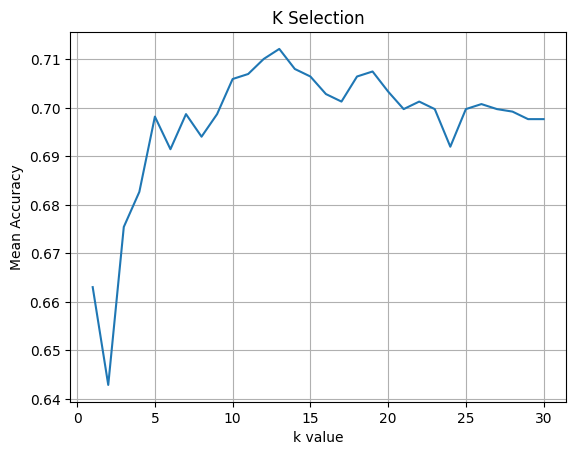

Best k: 13
Test set accuracy: 0.7293

"AD": 0,     # Alzheimer's Disease - Doença de Alzheimer
"CN": 1,     # Cognitively Normal - Cognitivamente Normal
"SMC": 2,    # Significant Memory Concern - Preocupação Significativa com a Memória
"EMCI": 3,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 4    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado


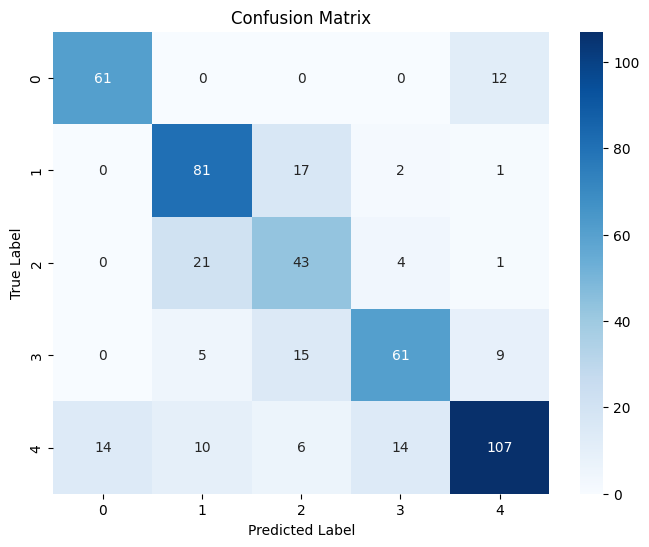

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        73
           1       0.69      0.80      0.74       101
           2       0.53      0.62      0.57        69
           3       0.75      0.68      0.71        90
           4       0.82      0.71      0.76       151

    accuracy                           0.73       484
   macro avg       0.72      0.73      0.72       484
weighted avg       0.74      0.73      0.73       484



In [36]:
#KNN
# Finding the best k
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('k value')
plt.ylabel('Mean Accuracy')
plt.title('K Selection')
plt.grid(True)
plt.show()

best_k = k_range[np.argmax(k_scores)]
print(f"Best k: {best_k}")

# Training the final model
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Evaluating on the test set
test_accuracy = best_knn.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Predictions and evaluation
y_pred = best_knn.predict(X_test_scaled)
print('''
"AD": 0,     # Alzheimer's Disease - Doença de Alzheimer
"CN": 1,     # Cognitively Normal - Cognitivamente Normal
"SMC": 2,    # Significant Memory Concern - Preocupação Significativa com a Memória
"EMCI": 3,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 4    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado''')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest test set accuracy: 0.8884

"AD": 0,     # Alzheimer's Disease - Doença de Alzheimer
"CN": 1,     # Cognitively Normal - Cognitivamente Normal
"SMC": 2,    # Significant Memory Concern - Preocupação Significativa com a Memória
"EMCI": 3,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 4    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado


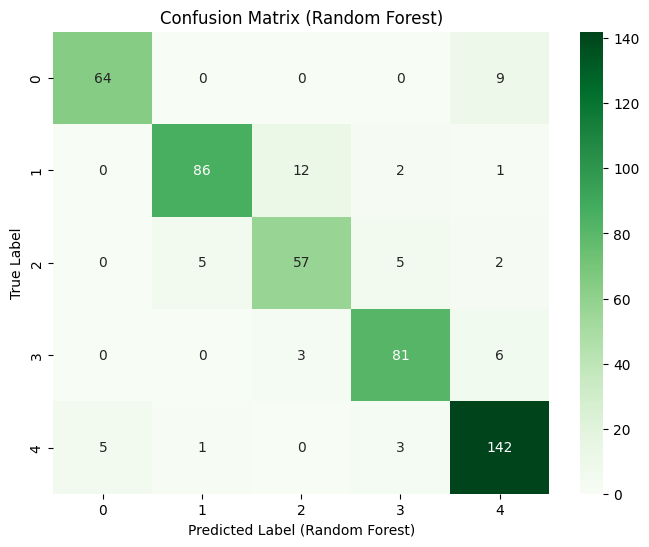


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        73
           1       0.93      0.85      0.89       101
           2       0.79      0.83      0.81        69
           3       0.89      0.90      0.90        90
           4       0.89      0.94      0.91       151

    accuracy                           0.89       484
   macro avg       0.89      0.88      0.88       484
weighted avg       0.89      0.89      0.89       484



In [38]:
#Random forest

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest test set accuracy: {accuracy_rf:.4f}")

print('''
"AD": 0,     # Alzheimer's Disease - Doença de Alzheimer
"CN": 1,     # Cognitively Normal - Cognitivamente Normal
"SMC": 2,    # Significant Memory Concern - Preocupação Significativa com a Memória
"EMCI": 3,   # Early Mild Cognitive Impairment - Comprometimento Cognitivo Leve Inicial
"LMCI": 4    # Late Mild Cognitive Impairment - Comprometimento Cognitivo Leve Avançado''')

# Display the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label (Random Forest)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Display the classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
